### Import packages

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import geopandas as gpd
import xarray as xr
from skimage import io
import subprocess
from osgeo import gdal, osr

from shapely.geometry import mapping

import cartopy.feature as cf
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker
import cartopy.feature as cf
from cartopy.util import add_cyclic_point

import rioxarray as rxr
import rasterio

import glob


import georaster
from mpl_toolkits.basemap import Basemap
import matplotlib.colors

# Plotting options
sns.set(font_scale=1.3)
sns.set_style("white")

## Datasets:

### Altimetry from Copernicus digital elevation model (DEM) v1.1: Downloaded here https://land.copernicus.eu/imagery-in-situ/eu-dem/eu-dem-v1.1 

### Tidal and storm surge contributions also from Copernicus from 'Water level change indicators for the European coast from 1977 to 2100 derived from climate projections'. Downloaded here: https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-water-level-change-indicators?tab=overview

Historical values from ERA5 reanalysis: from 1979 to 2005 

Separate the surge and tidal contributions to the extremes

### Key point is that both DEM and tide and storm surge contributions are referenced to mean sea level with the same vertical datum, presumably, since they come from the same data source: EPSG:3035 (ETRS89, LAEA) for the DEM
EVRS2000 vertical datum, geoid EGG08, more info in this fact sheet https://land.copernicus.eu/user-corner/publications/eu-dem-flyer/view

### Sea level rise from IPCC 
Visualization of sea level rise here: https://sealevel.nasa.gov/data_tools/17

## Load altimetry data from Copernicus

In [2]:
fp_dem = "/Users/annalea_albright/Dropbox/BPCE/Data/Copernicus_DEM_lat-lon_coarser.tif"
#"/Users/annalea_albright/Dropbox/BPCE/Data/Copernicus_dem_lat-lon.tif"

In [26]:
dem = rxr.open_rasterio(fp_dem).squeeze()
dem = dem.sel(x=slice(-5.0, 8.5)).sel(y=slice(52, 42.2))

print("The CRS for this data is:", dem.rio.crs) # dem.rio.crs.to_epsg()
print("The spatial extent is:", dem.rio.bounds())
print("The no data value is:", dem.rio.nodata)

dem

The CRS for this data is: EPSG:4326
The spatial extent is: (-5.000351906, 42.200211951, 8.499648094000001, 51.327211951)
The no data value is: -3.4028235e+38


<xarray.DataArray (y: 9127, x: 13500)>
[123214500 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 -5.0 -4.999 -4.998 -4.997 ... 8.497 8.498 8.499
  * y            (y) float64 51.33 51.33 51.32 51.32 ... 42.2 42.2 42.2 42.2
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        3718.3813476562
    STATISTICS_MEAN:           157.06170085189
    STATISTICS_MINIMUM:        -11.299710273743
    STATISTICS_STDDEV:         330.27678835505
    STATISTICS_VALID_PERCENT:  83.28
    _FillValue:                -3.4028235e+38
    scale_factor:              1.0
    add_offset:                0.0

In [27]:
dem = dem.where(dem != dem._FillValue) # dem.rio.nodata
dem = dem.where(dem != 0) # oceans

In [5]:
dem

<xarray.DataArray (y: 8800, x: 13500)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    band         int64 1
  * x            (x) float64 -5.0 -4.999 -4.998 -4.997 ... 8.497 8.498 8.499
  * y            (y) float64 51.0 51.0 51.0 51.0 51.0 ... 42.2 42.2 42.2 42.2
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -3.4028235e+38
    scale_factor:   1.0
    add_offset:     0.0

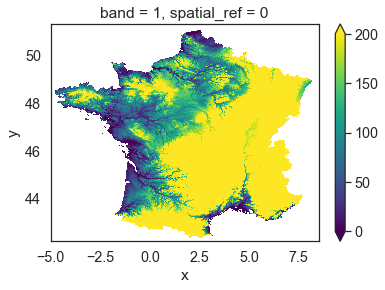

In [42]:
dem.plot(
        vmin=0,
         vmax=200,
)

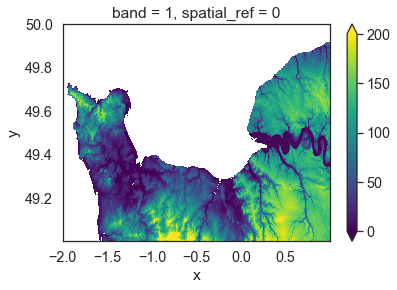

In [6]:
# plot a subset as test
dem.sel(x=slice(-2, 1)).sel(y=slice(50,49)).plot(
        vmin=0,
         vmax=200,
)

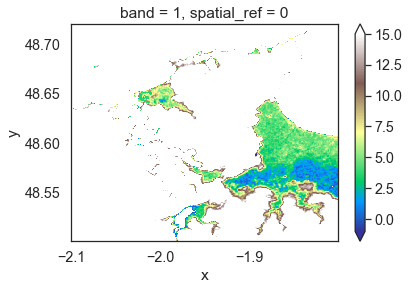

In [153]:
dem.sel(x=slice(-2.1, -1.8)).sel(y=slice(48.72, 48.5)).plot(vmin=-1,
                                                           vmax=15,
                                                           cmap="terrain")

## Shapefile of France to define regions at 1 km resolution

In [81]:
fp_shape = '/Users/annalea_albright/Dropbox/BPCE/Data/regions_shapefile/FRA_adm1.shp'
regions_gdf = gpd.read_file(fp_shape)
#print(regions_gdf)
region_names = regions_gdf.NAME_1.values # regions_gdf.columns
print('# of regions', len(region_names))
print('names of regions', region_names)

    ID_0  ISO  NAME_0  ID_1                      NAME_1 HASC_1  CCN_1 CCA_1  \
0     79  FRA  France     1                      Alsace   None      0    42   
1     79  FRA  France     2                   Aquitaine   None      0    72   
2     79  FRA  France     3                    Auvergne   None      0    83   
3     79  FRA  France     4               Île-de-France   None      0    11   
4     79  FRA  France     5             Basse-Normandie   None      0    25   
5     79  FRA  France     6                   Bourgogne   None      0    26   
6     79  FRA  France     7                    Bretagne   None      0    53   
7     79  FRA  France     8                      Centre   None      0    24   
8     79  FRA  France     9           Champagne-Ardenne   None      0    21   
9     79  FRA  France    10                       Corse   None      0    94   
10    79  FRA  France    11               Franche-Comté   None      0    43   
11    79  FRA  France    12             Haute-Norman

## Define regions in coastal zones for our analysis

In [28]:
zone1 = ['Nord-Pas-de-Calais', 'Picardie', 'Haute-Normandie', 'Basse-Normandie']
zone2 = ['Bretagne', 'Pays de la Loire', 'Poitou-Charentes']
zone3 = ['Aquitaine']
zone4 = ['Languedoc-Roussillon', "Provence-Alpes-Côte d'Azur"]

zones_coast = zone1 + zone2 + zone3 + zone4
print(zones_coast)

['Nord-Pas-de-Calais', 'Picardie', 'Haute-Normandie', 'Basse-Normandie', 'Bretagne', 'Pays de la Loire', 'Poitou-Charentes', 'Aquitaine', 'Languedoc-Roussillon', "Provence-Alpes-Côte d'Azur"]


In [46]:
# Convert both lists into sets
region_names_set = set(region_names)
zones_coast_set = set(zones_coast)

# Find the set difference to get the disjoint set
disjoint_set = region_names_set.difference(zones_coast_set)

# Convert the set back to a list (if needed)
interior_regions_list = list(disjoint_set)
interior_regions_list.remove('Corse')
interior_regions_list

['Lorraine',
 'Rhône-Alpes',
 'Champagne-Ardenne',
 'Centre',
 'Île-de-France',
 'Midi-Pyrénées',
 'Alsace',
 'Franche-Comté',
 'Limousin',
 'Auvergne',
 'Bourgogne']

## To do's

* load dataframes saved from previously

* For each region, find aoi_lat and aoi_lon

* select corresponding storm surge value and tide range

* add it to that part of the DEM 

* loop over regions

* look where < 0

* plot that

* add buffer? or in QGIS?

* export as geoTIFF


## Load data for each region calculated previously, in file 
`Update_calculate_area_of_interest_variables.ipynb`

In [65]:
def add_interior_regions(existing_df):
    # Create a new DataFrame with NaN values for the other regions
    new_rows = pd.DataFrame({
        'Region': interior_regions_list,
        'lat_min': 0,
        'lat_max': 0,
        'lon_min': 0,
        'lon_max': 0,
        'var_mean': 0,

    })

    # Concatenate the new DataFrame with the existing DataFrame
    updated_df = pd.concat([existing_df, new_rows], 
                           ignore_index=True
                          )
    return updated_df


folder_save = '/Users/annalea_albright/Dropbox/BPCE/Data/'

df_2_surge = pd.read_csv(os.path.join(folder_save, 'df_pd_2year_surge.csv'))
df_5_surge = pd.read_csv(os.path.join(folder_save, 'df_pd_5year_surge.csv'))
df_100_surge = pd.read_csv(os.path.join(folder_save, 'df_pd_100year_surge.csv'))
df_pd_tides = pd.read_csv(os.path.join(folder_save, 'df_pd_tides.csv'))

df_2_surge = add_interior_regions(df_2_surge)
print(df_2_surge)

df_100_surge = add_interior_regions(df_100_surge)
#print(df_100_surge)

df_pd_tides = add_interior_regions(df_pd_tides)

    Unnamed: 0                      Region    lat_min    lat_max     lon_min  \
0          0.0          Nord-Pas-de-Calais  49.970657  51.089397  361.555278   
1          1.0                    Picardie  48.838474  50.368549  361.379723   
2          2.0             Haute-Normandie  48.666523  50.071552  360.065138   
3          3.0             Basse-Normandie  48.180092  49.728195  357.935972   
4          4.0                    Bretagne  47.278751  49.105694  354.856249   
5          5.0            Pays de la Loire  46.266804  48.568001  357.373472   
6          6.0            Poitou-Charentes  45.089249  47.175758  358.436805   
7          7.0                   Aquitaine  42.777672  45.714569  358.211528   
8          8.0        Languedoc-Roussillon  42.333443  44.975723  361.688420   
9          9.0  Provence-Alpes-Côte d'Azur  42.981529  45.126846  364.229758   
10         NaN                    Lorraine   0.000000   0.000000    0.000000   
11         NaN                 Rhône-Alp

In [68]:
df_pd_tides.Region.values

array(['Nord-Pas-de-Calais', 'Picardie', 'Haute-Normandie',
       'Basse-Normandie', 'Bretagne', 'Pays de la Loire',
       'Poitou-Charentes', 'Aquitaine', 'Languedoc-Roussillon',
       "Provence-Alpes-Côte d'Azur", 'Lorraine', 'Rhône-Alpes',
       'Champagne-Ardenne', 'Centre', 'Île-de-France', 'Midi-Pyrénées',
       'Alsace', 'Franche-Comté', 'Limousin', 'Auvergne', 'Bourgogne'],
      dtype=object)

## Combine these values with DEM using shapefile, not a rectangle

In [8]:
# check that CRS is the same
print('shapefile extent crs: ', regions_gdf.crs)
print('DEM crs: ', dem.rio.crs)

shapefile extent crs:  epsg:4326
DEM crs:  EPSG:4326


## Individual examples

    ID_0  ISO  NAME_0  ID_1            NAME_1 HASC_1  CCN_1 CCA_1  TYPE_1  \
17    79  FRA  France    18  Pays de la Loire   None      0    52  Région   

   ENGTYPE_1 NL_NAME_1 VARNAME_1  \
17    Region      None      None   

                                             geometry  
17  MULTIPOLYGON (((-1.09291 46.31485, -1.09319 46...  
storm surge value 0.9186202702151116 m
tide value 2.8271089290784177 m


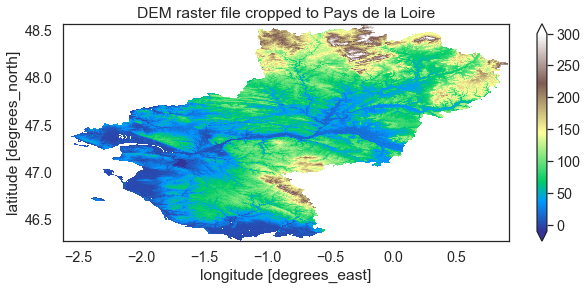

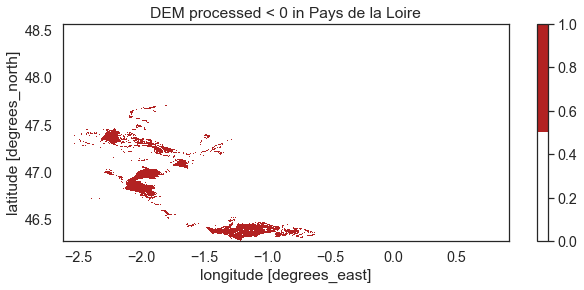

In [11]:
region_sel = 'Pays de la Loire' # 'Poitou-Charentes' #'Nord-Pas-de-Calais'

# select region shapefile
filtered_shapefile = regions_gdf[regions_gdf['NAME_1'] == region_sel] # Pays de la Loire
print(filtered_shapefile)

# clip DEM using shapefile
dem_clipped = dem.rio.clip(
                            filtered_shapefile.geometry.apply(mapping),
                          # Below is needed if your GDF is in a diff CRS than the raster data
                          regions_gdf.crs
                                     )
# somehow it requires again setting Fill Values and 0 (oceans) to NaN
dem_clipped = dem_clipped.where(dem_clipped != dem_clipped._FillValue) # dem.rio.nodata
dem_clipped = dem_clipped.where(dem_clipped != 0) # oceans

# storm surge
df = df_2_surge
surge_sel = df.loc[df["Region"] == region_sel, "var_mean"].values[0]
print('storm surge value', surge_sel, 'm')

# tide
tide_sel = df_pd_tides.loc[df_pd_tides["Region"] == region_sel, "var_mean"].values[0]
print('tide value', tide_sel, 'm')

# sea level rise value
sea_level_value = 0.2

# subtract values from DEM
dem_clipped_subtract = dem_clipped - surge_sel - tide_sel - sea_level_value

# plot, optional
if 1:
    # plots
    f, ax = plt.subplots(figsize=(10, 4))
    dem_clipped.plot(
            ax=ax, 
                     cmap="terrain", 
                     vmin=-10, 
                     vmax=300
                    )
    ax.set(title=f"DEM raster file cropped to {region_sel}")


    f, ax = plt.subplots(figsize=(10, 4))
    (dem_clipped_subtract<0).plot(
            ax=ax, 
                     #cmap="Reds", 
        vmin=0,
               vmax=1,
              cmap=matplotlib.colors.ListedColormap(['white', 'firebrick']), 
                    )
    ax.set(title=f"DEM processed < 0 in {region_sel}")
    
dem_clipped_subtract = None

    ID_0  ISO  NAME_0  ID_1    NAME_1 HASC_1  CCN_1 CCA_1  TYPE_1 ENGTYPE_1  \
14    79  FRA  France    15  Lorraine   None      0    41  Région    Region   

   NL_NAME_1 VARNAME_1                                           geometry  
14      None    Lorena  POLYGON ((5.42900 49.58920, 5.43495 49.57802, ...  
storm surge value nan m
tide value nan m


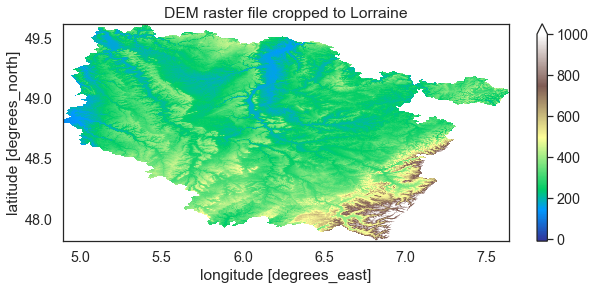

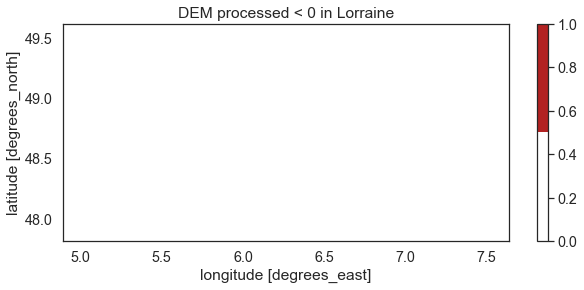

In [63]:
region_sel = 'Lorraine' # 'Poitou-Charentes' #'Nord-Pas-de-Calais'

# select region shapefile
filtered_shapefile = regions_gdf[regions_gdf['NAME_1'] == region_sel] # Pays de la Loire
print(filtered_shapefile)

# clip DEM using shapefile
dem_clipped = dem.rio.clip(
                            filtered_shapefile.geometry.apply(mapping),
                          # Below is needed if your GDF is in a diff CRS than the raster data
                          regions_gdf.crs
                                     )
# somehow it requires again setting Fill Values and 0 (oceans) to NaN
dem_clipped = dem_clipped.where(dem_clipped != dem_clipped._FillValue) # dem.rio.nodata
dem_clipped = dem_clipped.where(dem_clipped != 0) # oceans

# storm surge
df = df_2_surge
surge_sel = df.loc[df["Region"] == region_sel, "var_mean"].values[0]
print('storm surge value', surge_sel, 'm')

# tide
tide_sel = df_pd_tides.loc[df_pd_tides["Region"] == region_sel, "var_mean"].values[0]
print('tide value', tide_sel, 'm')

# sea level rise value
sea_level_value = 0.2

# subtract values from DEM
dem_clipped_subtract = dem_clipped - surge_sel - tide_sel - sea_level_value

# plot, optional
if 1:
    # plots
    f, ax = plt.subplots(figsize=(10, 4))
    dem_clipped.plot(
            ax=ax, 
                     cmap="terrain", 
                     vmin=-10, 
                     vmax=1000
                    )
    ax.set(title=f"DEM raster file cropped to {region_sel}")


    f, ax = plt.subplots(figsize=(10, 4))
    (dem_clipped_subtract<0).plot(
            ax=ax, 
                     #cmap="Reds", 
        vmin=0,
               vmax=1,
              cmap=matplotlib.colors.ListedColormap(['white', 'firebrick']), 
                    )
    ax.set(title=f"DEM processed < 0 in {region_sel}")
    
dem_clipped_subtract = None

    ID_0  ISO  NAME_0  ID_1              NAME_1 HASC_1  CCN_1 CCA_1  TYPE_1  \
16    79  FRA  France    17  Nord-Pas-de-Calais   None      0    31  Région   

   ENGTYPE_1 NL_NAME_1 VARNAME_1  \
16    Region      None      None   

                                             geometry  
16  MULTIPOLYGON (((2.34417 51.05653, 2.34417 51.0...  
storm surge value 1.7008450456195845 m
tide value 4.376885185813796 m


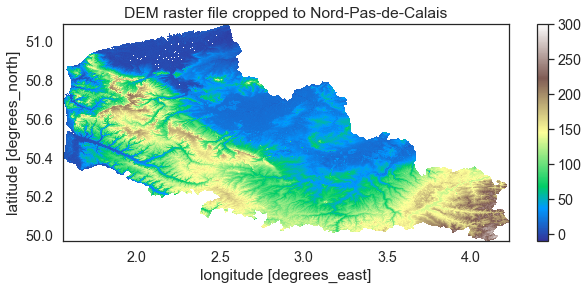

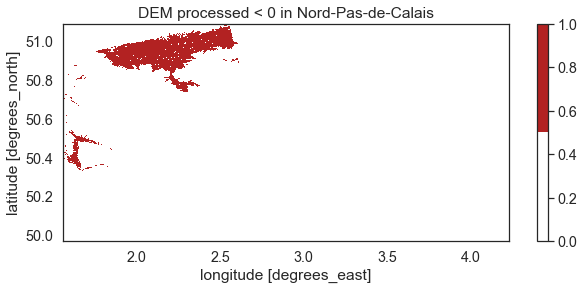

In [30]:
region_sel = 'Nord-Pas-de-Calais' # 'Poitou-Charentes' #'Nord-Pas-de-Calais'

# select region shapefile
filtered_shapefile = regions_gdf[regions_gdf['NAME_1'] == region_sel] # Pays de la Loire
print(filtered_shapefile)

# clip DEM using shapefile
dem_clipped = dem.rio.clip(
                            filtered_shapefile.geometry.apply(mapping),
                          # Below is needed if your GDF is in a diff CRS than the raster data
                          regions_gdf.crs
                                     )
# somehow it requires again setting Fill Values and 0 (oceans) to NaN
dem_clipped = dem_clipped.where(dem_clipped != dem_clipped._FillValue) # dem.rio.nodata
dem_clipped = dem_clipped.where(dem_clipped != 0) # oceans

# storm surge
df = df_2_surge
surge_sel = df.loc[df["Region"] == region_sel, "var_mean"].values[0]
print('storm surge value', surge_sel, 'm')

# tide
tide_sel = df_pd_tides.loc[df_pd_tides["Region"] == region_sel, "var_mean"].values[0]
print('tide value', tide_sel, 'm')

# sea level rise value
sea_level_value = 0.2

# subtract values from DEM
dem_clipped_subtract = dem_clipped - surge_sel - tide_sel - sea_level_value

# plot, optional
if 1:
    # plots
    f, ax = plt.subplots(figsize=(10, 4))
    dem_clipped.plot(
            ax=ax, 
                     cmap="terrain", 
                     vmin=-10, 
                     vmax=300
                    )
    ax.set(title=f"DEM raster file cropped to {region_sel}")


    f, ax = plt.subplots(figsize=(10, 4))
    (dem_clipped_subtract<0).plot(
            ax=ax, 
                     #cmap="Reds", 
        vmin=0,
               vmax=1,
              cmap=matplotlib.colors.ListedColormap(['white', 'firebrick']), 
                    )
    ax.set(title=f"DEM processed < 0 in {region_sel}")
    
dem_clipped_subtract = None

   ID_0  ISO  NAME_0  ID_1    NAME_1 HASC_1  CCN_1 CCA_1  TYPE_1 ENGTYPE_1  \
6    79  FRA  France     7  Bretagne   None      0    53  Région    Region   

  NL_NAME_1         VARNAME_1  \
6      None  Bretaña|Brittany   

                                            geometry  
6  MULTIPOLYGON (((-3.25097 47.31181, -3.25097 47...  
storm surge value 0.9368298306973936 m
tide value 4.23976352418337 m


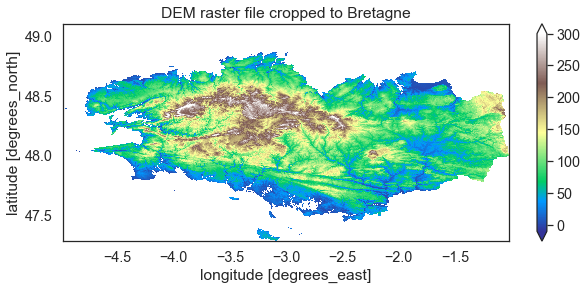

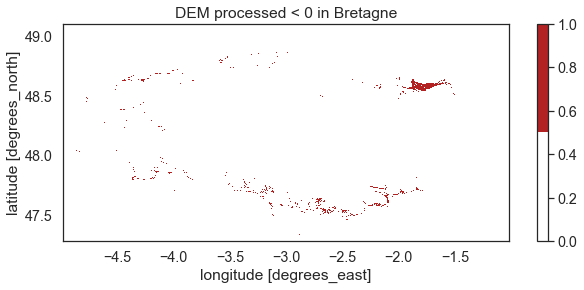

In [147]:
region_sel = 'Bretagne' # 'Poitou-Charentes' #'Nord-Pas-de-Calais'

# select region shapefile
filtered_shapefile = regions_gdf[regions_gdf['NAME_1'] == region_sel] # Pays de la Loire
print(filtered_shapefile)

# clip DEM using shapefile
dem_clipped = dem.rio.clip(
                            filtered_shapefile.geometry.apply(mapping),
                          # Below is needed if your GDF is in a diff CRS than the raster data
                          regions_gdf.crs
                                     )
# somehow it requires again setting Fill Values and 0 (oceans) to NaN
dem_clipped = dem_clipped.where(dem_clipped != dem_clipped._FillValue) # dem.rio.nodata
dem_clipped = dem_clipped.where(dem_clipped != 0) # oceans

# storm surge
df = df_2_surge
surge_sel = df.loc[df["Region"] == region_sel, "var_mean"].values[0]
print('storm surge value', surge_sel, 'm')

# tide
tide_sel = df_pd_tides.loc[df_pd_tides["Region"] == region_sel, "var_mean"].values[0]
print('tide value', tide_sel, 'm')

# sea level rise value
sea_level_value = 0.2

# subtract values from DEM
dem_clipped_subtract = dem_clipped - surge_sel - tide_sel - sea_level_value

# plot, optional
if 1:
    # plots
    f, ax = plt.subplots(figsize=(10, 4))
    dem_clipped.plot(
            ax=ax, 
                     cmap="terrain", 
                     vmin=-10, 
                     vmax=300
                    )
    ax.set(title=f"DEM raster file cropped to {region_sel}")


    f, ax = plt.subplots(figsize=(10, 4))
    (dem_clipped_subtract<0).plot(
            ax=ax, 
                     #cmap="Reds", 
        vmin=0,
               vmax=1,
              cmap=matplotlib.colors.ListedColormap(['white', 'firebrick']), 
                    )
    ax.set(title=f"DEM processed < 0 in {region_sel}")
    
dem_clipped_subtract = None

## create files for 3 scenarios: only tides, and then low and high climate scenarios

In [69]:
def calculate_height_for_each_AOI_and_combine(
                            sea_level_value,
                            df_storm_surge,
                            tides_only=False,

                        ):
    
    if tides_only == True:
        scenario_name="tides_only"
    if (sea_level_value == 0.2) & (tides_only==False):
        scenario_name="low_scenario"
    if (sea_level_value == 0.6) & (tides_only==False):
         scenario_name="high_scenario"

   
    for count, region_sel in enumerate(df_pd_tides.Region.values):
        #zones_coast):

        print(region_sel)
        
        filtered_shapefile = regions_gdf[regions_gdf['NAME_1'] == region_sel] 
        #print(filtered_shapefile)

        # clip DEM using shapefile
        dem_clipped = dem.rio.clip(
                                    filtered_shapefile.geometry.apply(mapping),
                                  # Below is needed if your GDF is in a diff CRS than the raster data
                                  regions_gdf.crs
                                             )

        # somehow it requires again setting Fill Values and 0 (oceans) to NaN
        dem_clipped = dem_clipped.where(dem_clipped != dem_clipped._FillValue) # dem.rio.nodata
        dem_clipped = dem_clipped.where(dem_clipped != 0) # oceans

        # storm surge
        surge_sel = df_storm_surge.loc[df_storm_surge["Region"] == region_sel, "var_mean"].values[0]
        # tide
        tide_sel = df_pd_tides.loc[df_pd_tides["Region"] == region_sel, "var_mean"].values[0]

        print('storm surge value', surge_sel, 'm')
        #print('tide value', tide_sel, 'm')
        
        if tides_only==True:
            dem_clipped_subtract = dem_clipped - tide_sel 
        else:
            # subtract values
            dem_clipped_subtract = dem_clipped - surge_sel - tide_sel - sea_level_value

        fp_save = f'/Users/annalea_albright/Dropbox/BPCE/Data/save_regions/{scenario_name}/{count}_test_subtract.nc'
        dem_clipped_subtract.to_netcdf(fp_save)

        # plot?
        if 0:
            # plots
            f, ax = plt.subplots(figsize=(10, 4))
            dem_clipped.plot(
                    ax=ax, 
                             cmap="terrain", 
                             vmin=-10, 
                             vmax=300
                            )
            ax.set(title=f"DEM raster file cropped to {region_sel}")


            f, ax = plt.subplots(figsize=(10, 4))
            (dem_clipped_subtract<0).plot(
                    ax=ax, 
                             #cmap="Reds", 
                vmin=0,
                       vmax=1,
                      cmap=matplotlib.colors.ListedColormap(['white', 'firebrick']), 
                            )
            ax.set(title=f"DEM processed < 0 in {region_sel}")
        
                
        # remove after each run to save memory
        dem_clipped_subtract=None
    
    ### now recombine and save as new geoTIFF files
    
    # find all filenames that match
    folder_path = f"/Users/annalea_albright/Dropbox/BPCE/Data/save_regions/{scenario_name}/"
    file_pattern = "*test_subtract.nc"
    search_path = f"{folder_path}/{file_pattern}"
    input_files = glob.glob(search_path) 
    
    # open and merge as xarray
    datasets = [xr.open_dataset(file) for file in input_files]
    combined_dataset = xr.merge(datasets, 
                            #dim=None,
                             #dim=['x', 'y']
                            )
    fp_save_combined = f'/Users/annalea_albright/Dropbox/BPCE/Data/save_regions/processed_DEM_{scenario_name}.nc'
    combined_dataset.to_netcdf(fp_save_combined)
    
    return combined_dataset


        

In [70]:
combined_dataset_low_scenario = calculate_height_for_each_AOI_and_combine(
                            sea_level_value=0.2, 
    # 0.6
                            df_storm_surge=df_2_surge, 
    # df_100_surge
                            tides_only=False,

                        )    


Nord-Pas-de-Calais
storm surge value 1.7008450456195845 m
Picardie
storm surge value 2.0915326937636154 m
Haute-Normandie
storm surge value 1.5512007260598544 m
Basse-Normandie
storm surge value 1.376926151399858 m
Bretagne
storm surge value 0.9368298306973936 m
Pays de la Loire
storm surge value 0.9186202702151116 m
Poitou-Charentes
storm surge value 0.8675616622840486 m
Aquitaine
storm surge value 0.5859836380647248 m
Languedoc-Roussillon
storm surge value 0.3886122509798043 m
Provence-Alpes-Côte d'Azur
storm surge value 0.3565415271165799 m
Lorraine
storm surge value 0.0 m
Rhône-Alpes
storm surge value 0.0 m
Champagne-Ardenne
storm surge value 0.0 m
Centre
storm surge value 0.0 m
Île-de-France
storm surge value 0.0 m
Midi-Pyrénées
storm surge value 0.0 m
Alsace
storm surge value 0.0 m
Franche-Comté
storm surge value 0.0 m
Limousin
storm surge value 0.0 m
Auvergne
storm surge value 0.0 m
Bourgogne
storm surge value 0.0 m


In [124]:
combined_dataset_low_scenario['__xarray_dataarray_variable__'].dtype

dtype('float32')

In [74]:
combined_dataset_low_scenario

<xarray.Dataset>
Dimensions:                        (x: 13221, y: 8756)
Coordinates:
  * x                              (x) float64 -4.988 -4.987 ... 8.231 8.232
  * y                              (y) float64 42.33 42.33 42.34 ... 51.09 51.09
    band                           int64 1
    spatial_ref                    int64 0
Data variables:
    __xarray_dataarray_variable__  (y, x) float32 nan nan nan ... nan nan nan

In [18]:
combined_dataset_low_scenario['__xarray_dataarray_variable__'].values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

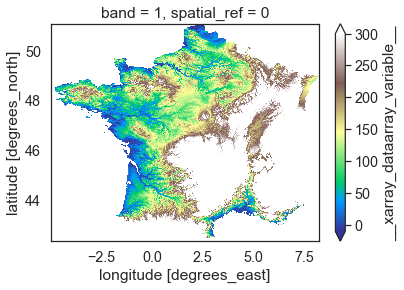

In [78]:
combined_dataset_low_scenario['__xarray_dataarray_variable__'].plot(
                                                    vmin=-10,
                                                      vmax=300,
                                                    cmap="terrain",
                                                      )

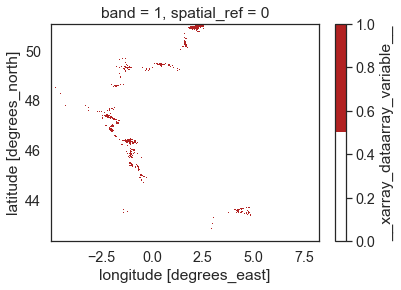

In [89]:
(combined_dataset_low_scenario['__xarray_dataarray_variable__']<0).plot(
                                                    vmin=0,
                                                      vmax=1,
                                                    cmap=matplotlib.colors.ListedColormap(['white', 'firebrick']), 
                                                      )

In [130]:
# Define the GeoTIFF file path for saving
output_tiff='/Users/annalea_albright/Dropbox/BPCE/Data/low_scenario.tif'

# Save the xarray dataset as a new GeoTIFF
combined_dataset_low_scenario['__xarray_dataarray_variable__'].to_dataset(name='data').rio.to_raster(output_tiff)

## Do the same for high scenario, and tides only

In [132]:
combined_dataset_high_scenario = calculate_height_for_each_AOI_and_combine(
                            sea_level_value=0.6, 
                            df_storm_surge=df_100_surge, 
                            tides_only=False,
                        )    

Nord-Pas-de-Calais
storm surge value 2.929928239488415 m
Picardie
storm surge value 3.677450830959908 m
Haute-Normandie
storm surge value 2.7474972627063723 m
Basse-Normandie
storm surge value 2.3442367679604565 m
Bretagne
storm surge value 1.5213646705850372 m
Pays de la Loire
storm surge value 1.55429702417016 m
Poitou-Charentes
storm surge value 1.4636735797682012 m
Aquitaine
storm surge value 0.9588421973107072 m
Languedoc-Roussillon
storm surge value 0.6447335633101279 m
Provence-Alpes-Côte d'Azur
storm surge value 0.5958141942711574 m
Lorraine
storm surge value 0.0 m
Rhône-Alpes
storm surge value 0.0 m
Champagne-Ardenne
storm surge value 0.0 m
Centre
storm surge value 0.0 m
Île-de-France
storm surge value 0.0 m
Midi-Pyrénées
storm surge value 0.0 m
Alsace
storm surge value 0.0 m
Franche-Comté
storm surge value 0.0 m
Limousin
storm surge value 0.0 m
Auvergne
storm surge value 0.0 m
Bourgogne
storm surge value 0.0 m


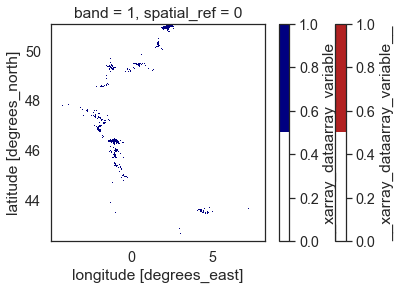

In [134]:
(combined_dataset_high_scenario['__xarray_dataarray_variable__']<0).plot(
                                                    vmin=0,
                                                      vmax=1,
                                                    cmap=matplotlib.colors.ListedColormap(['white', 'firebrick']), 
                                                      )

(combined_dataset_low_scenario['__xarray_dataarray_variable__']<0).plot(
                                                    vmin=0,
                                                      vmax=1,
                                                    cmap=matplotlib.colors.ListedColormap(['white', 'navy']), 
                                                      )

In [135]:
# Define the GeoTIFF file path for saving
output_tiff='/Users/annalea_albright/Dropbox/BPCE/Data/high_scenario.tif'

# Save the xarray dataset as a new GeoTIFF
combined_dataset_high_scenario['__xarray_dataarray_variable__'].to_dataset(name='data').rio.to_raster(output_tiff)

In [136]:
combined_dataset_tides_only = calculate_height_for_each_AOI_and_combine(
                            sea_level_value=0.0, 
                            df_storm_surge=df_2_surge, 
                            tides_only=True,

                        )    


Nord-Pas-de-Calais
storm surge value 1.7008450456195845 m
Picardie
storm surge value 2.0915326937636154 m
Haute-Normandie
storm surge value 1.5512007260598544 m
Basse-Normandie
storm surge value 1.376926151399858 m
Bretagne
storm surge value 0.9368298306973936 m
Pays de la Loire
storm surge value 0.9186202702151116 m
Poitou-Charentes
storm surge value 0.8675616622840486 m
Aquitaine
storm surge value 0.5859836380647248 m
Languedoc-Roussillon
storm surge value 0.3886122509798043 m
Provence-Alpes-Côte d'Azur
storm surge value 0.3565415271165799 m
Lorraine
storm surge value 0.0 m
Rhône-Alpes
storm surge value 0.0 m
Champagne-Ardenne
storm surge value 0.0 m
Centre
storm surge value 0.0 m
Île-de-France
storm surge value 0.0 m
Midi-Pyrénées
storm surge value 0.0 m
Alsace
storm surge value 0.0 m
Franche-Comté
storm surge value 0.0 m
Limousin
storm surge value 0.0 m
Auvergne
storm surge value 0.0 m
Bourgogne
storm surge value 0.0 m


In [138]:
# Define the GeoTIFF file path for saving
output_tiff='/Users/annalea_albright/Dropbox/BPCE/Data/tides_only.tif'

# Save the xarray dataset as a new GeoTIFF
combined_dataset_tides_only['__xarray_dataarray_variable__'].to_dataset(name='data').rio.to_raster(output_tiff)

In [141]:
def make_plot_differences_zones(
                        xrange,
                         yrange
):
    plt.figure(figsize=(20,10))
    combined_dataset_high_scenario_sel = combined_dataset_high_scenario['__xarray_dataarray_variable__'].sel(x=xrange).sel(y=yrange)
    (combined_dataset_high_scenario_sel<0).plot(
        vmin=0,
               vmax=1,
              #vmin=-10,
              #vmax=0
              cmap=matplotlib.colors.ListedColormap(['white', 'navy']), # crimson,
    )


    combined_dataset_low_scenario_sel = combined_dataset_low_scenario['__xarray_dataarray_variable__'].sel(x=xrange).sel(y=yrange)
    (combined_dataset_low_scenario_sel<0).plot(
        vmin=0,
               vmax=1,
              #vmin=-10,
              #vmax=0,
              cmap=matplotlib.colors.ListedColormap(['white', 'firebrick']), # crimson,
        alpha=0.5,

    )

    combined_dataset_tides_only_sel = combined_dataset_tides_only['__xarray_dataarray_variable__'].sel(x=xrange).sel(y=yrange)
    (combined_dataset_tides_only_sel<0).plot(
        vmin=0,
               vmax=1,
              #vmin=-10,
              #vmax=0,
              cmap=matplotlib.colors.ListedColormap(['white', 'yellow']), # crimson,
        alpha=0.5,

    )

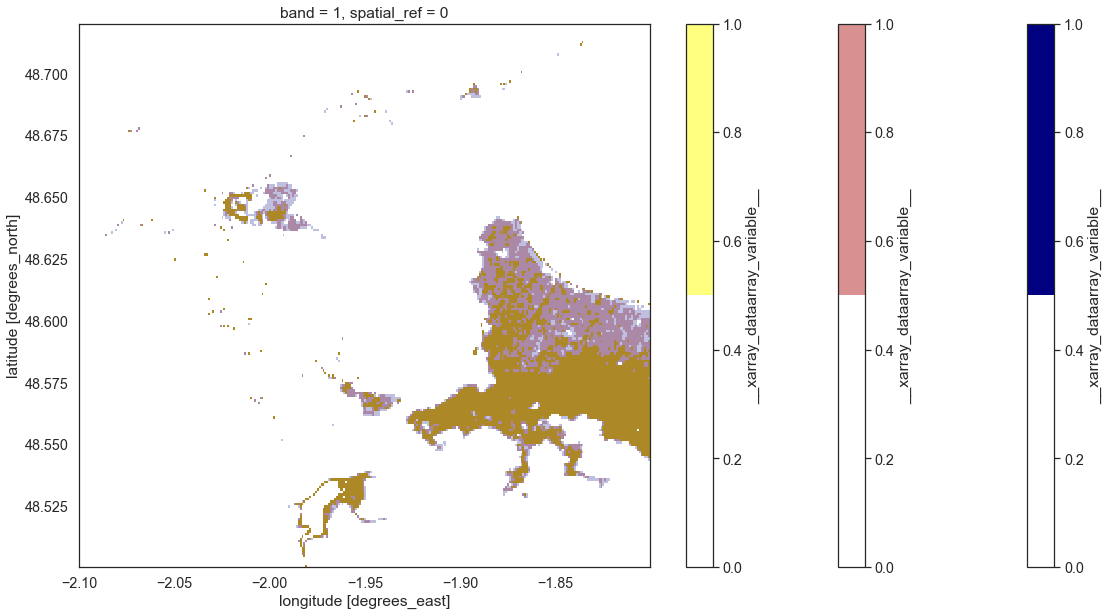

In [143]:
xrange = slice(-2.1, -1.8)
yrange = slice(48.5, 48.72)

make_plot_differences_zones(
                        xrange,
                         yrange
)

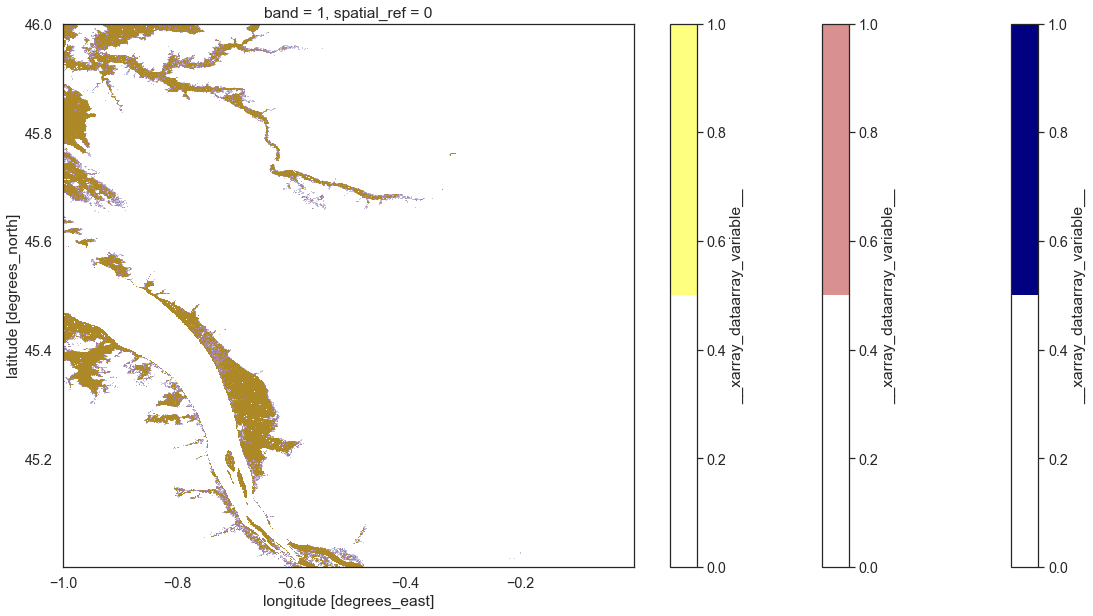

In [145]:
xrange = slice(-1, 0)
yrange = slice(45,46)

make_plot_differences_zones(
                        xrange,
                         yrange
)

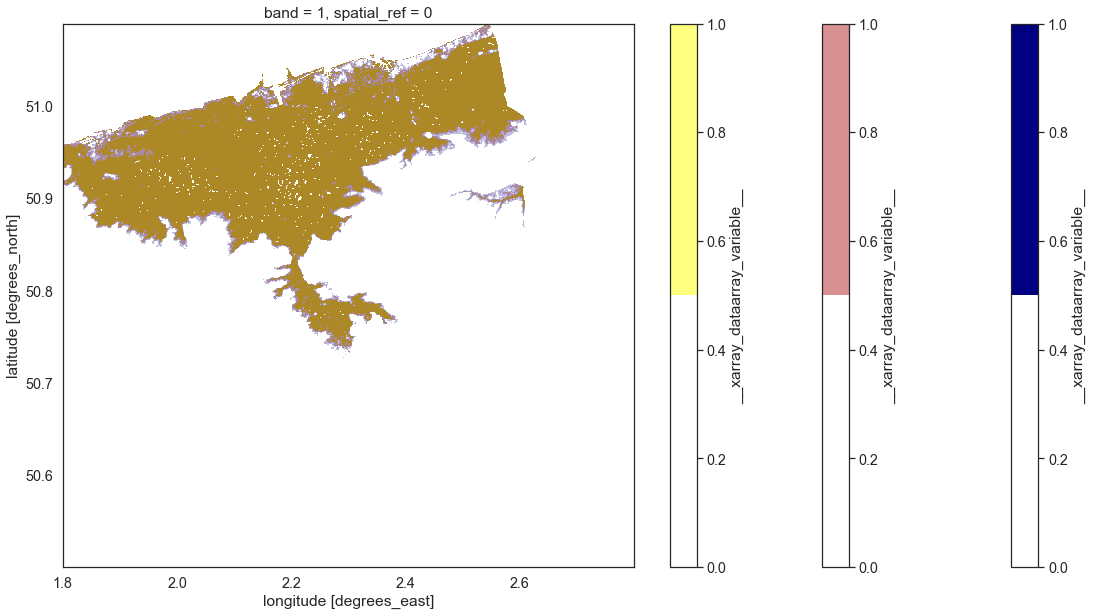

In [146]:
xrange = slice(1.8, 2.8)
yrange = slice(50.5, 51.3)

make_plot_differences_zones(
                        xrange,
                         yrange
)

## also specify sea level rise level `sea_level_rise` parameter

* under SSP3-7.0 scenario (medium-high, business as usual)
*  `sea_level_rise` = 0.2 for 2050
*  `sea_level_rise` = 0.4 for 2075
*  `sea_level_rise` = 0.6 for 2100 

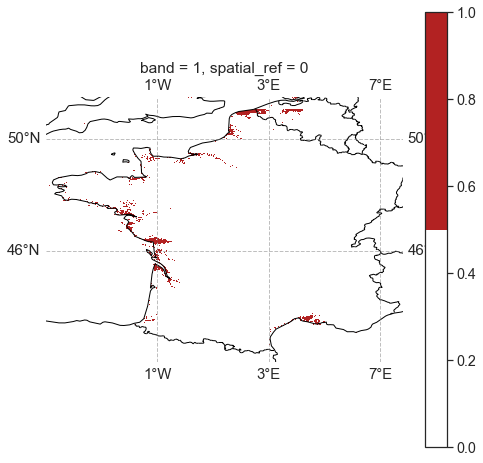

In [229]:
myproj = ccrs.PlateCarree()

plt.figure(figsize=(14, 14))
ax = plt.axes(projection=myproj)

im = (dem_100<0).plot(
    ax=ax,
    vmin=0,
           vmax=1,
          cmap=matplotlib.colors.ListedColormap(['white', 'firebrick']), 
    # darkred, firebrick, crimson #cmap_binary,

)

ax.coastlines(resolution='50m', color="black") # 10m

ax.add_feature(cf.BORDERS)
lon_left, lon_right = -5, 7.8
lat_S, lat_N = 42, 51.5
ax.set_extent([lon_left, lon_right, lat_S, lat_N])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
gl = ax.gridlines(color='Grey',draw_labels=True, alpha=0.5, linestyle='--')
gl_space = 4
gl.xlocator = mticker.FixedLocator(np.arange(lon_left-gl_space, lon_right+gl_space, gl_space))
gl.ylocator = mticker.FixedLocator(np.arange(lat_S-gl_space, lat_N+gl_space, gl_space))
fs = 15
gl.xlabel_style = {'size': fs}
gl.ylabel_style = {'size': fs}

#plt.title(title)

ax.axis('off')
right_side = ax.spines["right"]
right_side.set_visible(False)
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.box(on=None)

# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# cb = plt.colorbar(im, cax=cax, ticks=[0,1])
# cb.set_label(label="X", size='large', 
#              #weight='bold'
#             )
    
# # Add colorbar, make sure to specify tick locations to match desired ticklabels
# cbar = fig.colorbar(cax, ticks=[0, 1])
# cbar.ax.set_yticklabels(['0', '1'])  # vertically oriented colorbar